In [15]:
cd C:\2017\Work\Python\Kaggle\WSDM

C:\2017\Work\Python\Kaggle\WSDM


In [2]:
import pandas as pd

train_tran1 = pd.read_csv("train_lin_rand_xgb1.csv")
test_tran1 = pd.read_csv("test_lin_rand_xgb1.csv")

In [2]:
import pandas as pd
train_tran_mem_user = pd.read_csv("train_tran_mem_user.csv")
test_tran_mem_user = pd.read_csv("test_tran_mem_user.csv")


train_tran1 = train_tran_mem_user.drop_duplicates(keep="first", subset = ["msno"])# dropped duplicated column from transaction
test_tran1 = test_tran_mem_user.drop_duplicates(keep="first", subset = ["msno"])
train_tran1.reset_index(inplace=False)
test_tran1.reset_index(inplace=False)

train_tran1['gender'] = train_tran1['gender'].map({'female': 2, 'male': 1})
test_tran1['gender'] = test_tran1['gender'].map({'female': 2, 'male': 1})

train_tran1 = train_tran1.fillna(0)
test_tran1 = test_tran1.fillna(0)

#train_tran1.loc[train_tran1['bd'] < 0, 'bd'] = 0
#train_tran1.loc[train_tran1['bd'] > 80, 'bd'] = 0

#test_tran1.loc[test_tran1['bd'] < 0, 'bd'] = 0
#test_tran1.loc[test_tran1['bd'] > 80, 'bd'] = 0


train_tran1["discount"]= [int(i) for i in (train_tran1["plan_list_price"] - train_tran1["actual_amount_paid"])]
train_tran1.loc[train_tran1['discount'] < 0, 'discount'] = 0
test_tran1["discount"]= [int(i) for i in (test_tran1["plan_list_price"] - test_tran1["actual_amount_paid"])]
test_tran1.loc[test_tran1['discount'] < 0, 'discount'] = 0

In [ ]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import model_selection, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search


In [3]:
dummy_city = pd.get_dummies(train_tran1["city"], prefix="city")
train_tran1 = pd.concat([train_tran1, dummy_city], axis=1)

dummy_city1 = pd.get_dummies(test_tran1["city"], prefix="city")
test_tran1 = pd.concat([test_tran1, dummy_city1], axis=1)

dummy_regvia = pd.get_dummies(train_tran1["registered_via"], prefix="regv")
train_tran1 = pd.concat([train_tran1, dummy_regvia], axis=1)

dummy_regvia1 = pd.get_dummies(test_tran1["registered_via"], prefix="regv")
test_tran1 = pd.concat([test_tran1, dummy_regvia1], axis=1)

In [4]:
import numpy as np
train_tran1['is_discount'] = train_tran1.discount.apply(lambda x: 1 if x > 0 else 0)
test_tran1['is_discount'] = test_tran1.discount.apply(lambda x: 1 if x > 0 else 0)
test_tran1['autorenew_&_not_cancel'] = ((test_tran1.is_auto_renew == 1) == (test_tran1.is_cancel == 0)).astype(np.int8)
train_tran1['autorenew_&_not_cancel'] = ((train_tran1.is_auto_renew == 1) == (train_tran1.is_cancel == 0)).astype(np.int8)
train_tran1['notAutorenew_&_cancel'] = ((train_tran1.is_auto_renew == 0) == (train_tran1.is_cancel == 1)).astype(np.int8)
test_tran1['notAutorenew_&_cancel'] = ((test_tran1.is_auto_renew == 0) == (test_tran1.is_cancel == 1)).astype(np.int8)

In [5]:
def process_age(df,cut_points,label_names):
    df["bd"] = df["bd"].fillna(-0.5)
    df["bd_categories"] = pd.cut(df["bd"],cut_points,labels=label_names)
    return df

cut_points = [-4000,0,18,30,50,3000]
label_names = ["Missing","Child","Young","Adult","Older"]

train_tran1 = process_age(train_tran1,cut_points,label_names)
test_tran1 = process_age(test_tran1,cut_points,label_names)

dummy_bd = pd.get_dummies(train_tran1["bd_categories"], prefix="bdc")
train_tran1 = pd.concat([train_tran1, dummy_bd], axis=1)

dummy_bd = pd.get_dummies(test_tran1["bd_categories"], prefix="bdc")
test_tran1 = pd.concat([test_tran1, dummy_bd], axis=1)

In [22]:
Membership = []

for i in test_tran1["Membership_se_days"]:
    if i <= 0:
        i=0.5
    Membership.append(i)
    
test_tran1["Member"] = Membership

import numpy as np
Membership = []
for i in test_tran1["Member"]:
    try:
        i = np.log(i)
    except ValueError:
        i = 0
    Membership.append(i)
    
test_tran1["Member"] = Membership  

In [ ]:
train_tran1['transact_mem_exp_date'] = pd.to_datetime(train_tran1['transact_mem_exp_date'])
train_tran1['transact_mem_exp_date'].head()
train_tran1.info()

In [28]:
train1 = train_tran1[(train_tran1['transact_mem_exp_date'] < '2017-03-01')]

In [30]:
train2 = train_tran1[(train_tran1['transact_mem_exp_date'] > '2017-03-01') & (train_tran1['transact_mem_exp_date'] < '2017-04-01')]

In [23]:
predictors = ['payment_method_id', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'bd','gender','registration_init_time','date_count', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs',
 'discount', 'is_auto_renew','is_cancel','autorenew_&_not_cancel','notAutorenew_&_cancel','city_0.0', 'city_1.0', 'city_3.0', 'city_4.0', 'city_5.0', 'city_6.0', 'city_7.0', 'city_8.0', 'city_9.0', 'city_10.0',
 'city_11.0', 'city_12.0', 'city_13.0', 'city_14.0', 'city_15.0', 'city_16.0', 'city_17.0', 'city_18.0', 'city_19.0', 'city_20.0',
 'city_21.0', 'city_22.0', 'regv_0.0', 'regv_3.0', 'regv_4.0', 'regv_7.0', 'regv_9.0', 'regv_13.0',"bag_sci_col",'lin_reg_predict','xgboost_cls_predict' ,"dec_sci_col"]

In [7]:
predictors = ['payment_method_id', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'bdc_Adult','bdc_Child',
              'bdc_Missing','bdc_Older','bdc_Young','gender','date_count', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs',
 'discount', 'is_discount','is_auto_renew','is_cancel','city_0.0', 'city_1.0', 'city_3.0', 'city_4.0', 'city_5.0', 'city_6.0', 'city_7.0', 'city_8.0', 'city_9.0', 'city_10.0',
 'city_11.0', 'city_12.0', 'city_13.0', 'city_14.0', 'city_15.0', 'city_16.0', 'city_17.0', 'city_18.0', 'city_19.0', 'city_20.0',
 'city_21.0', 'city_22.0', 'regv_0.0', 'regv_3.0', 'regv_4.0', 'regv_7.0', 'regv_9.0', 'regv_13.0']

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

columns = predictors

all_X = train_tran1[columns]
all_y = train_tran1["is_churn"]

lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)
optimized_columns = all_X.columns[selector.support_]

In [ ]:
test_tran1.info()

In [ ]:
train_tran1.info()

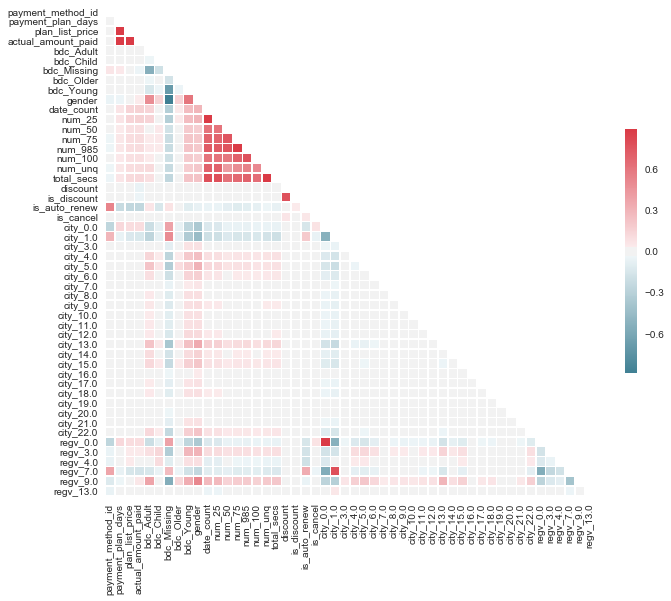

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = predictors

plot_correlation_heatmap(train_tran1[columns])

In [8]:
import sklearn.utils
train_random = sklearn.utils.shuffle(train_tran1)
#print('\n\ntrain_random: {0}'.format(train_random))
train_data = train_random.reset_index(drop=True)

In [8]:
train = train_data[1:600000]
test = train_data[600001:]

In [10]:
cols = predictors

train = train_data
test = test_tran1



import sys
import gc; gc.enable()
import collections
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn

In [ ]:
def xgb_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'log_loss', sklearn.metrics.log_loss(labels, preds)

fold = 1
for i in range(fold):
    params = {
        'eta': 0.002, #use 0.002
        'max_depth': 7,
        'subsample': 0.5,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': i,
        'silent': True
    }
    x1, x2, y1, y2 = sklearn.model_selection.train_test_split(train[cols], train['is_churn'], test_size=0.3, random_state=i)
    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x1, y1), 2000,  watchlist, feval=xgb_score, maximize=False, verbose_eval=50, early_stopping_rounds=50) #use 1500
    if i != 0:
        pred += model.predict(xgb.DMatrix(test[cols]), ntree_limit=model.best_ntree_limit)
    else:
        pred = model.predict(xgb.DMatrix(test[cols]), ntree_limit=model.best_ntree_limit)
pred /= fold
test_predictions5 = pred.clip(0.0000001, 0.999999)

[0]	train-logloss:0.691433	valid-logloss:0.691435	train-log_loss:0.691433	valid-log_loss:0.691435
Multiple eval metrics have been passed: 'valid-log_loss' will be used for early stopping.

Will train until valid-log_loss hasn't improved in 50 rounds.
[50]	train-logloss:0.613715	valid-logloss:0.613807	train-log_loss:0.613715	valid-log_loss:0.613807
[100]	train-logloss:0.549071	valid-logloss:0.549243	train-log_loss:0.549072	valid-log_loss:0.549243
[150]	train-logloss:0.494509	valid-logloss:0.494757	train-log_loss:0.494509	valid-log_loss:0.494757
[200]	train-logloss:0.447744	valid-logloss:0.44807	train-log_loss:0.447744	valid-log_loss:0.44807
[250]	train-logloss:0.407638	valid-logloss:0.408038	train-log_loss:0.407638	valid-log_loss:0.408038
[300]	train-logloss:0.37304	valid-logloss:0.373508	train-log_loss:0.37304	valid-log_loss:0.373508
[350]	train-logloss:0.34305	valid-logloss:0.343585	train-log_loss:0.34305	valid-log_loss:0.343585
[400]	train-logloss:0.316945	valid-logloss:0.317545	trai

In [12]:
min(test_predictions5)

0.0095062237

In [13]:
max(test_predictions5)

0.97676885

In [18]:
from sklearn.metrics import mean_squared_error
#train_mse = mean_squared_error(train_predictions, train['is_churn'])
test_mse = mean_squared_error(test_predictions, test['is_churn'])
import numpy as np
#train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
#print(train_rmse)
print(test_rmse)

0.184437442281


In [26]:
submission = pd.DataFrame({
    "is_churn": test_predictions,
        "msno": test_tran1["msno"]        
    })

submission.to_csv("sample_submission_new87.csv", index=False)

In [42]:
predictions = pd.DataFrame({
    "1": test_predictions1,
    "2": test_predictions2,
    "3": test_predictions3,
    "4": test_predictions4
               
    })

predictions.to_csv("test_predictions.csv", index=False)

Linear regression model - first base model

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_tran1[predictors], train_tran1['is_churn'])
from sklearn.metrics import mean_squared_error
train_predictions1 = lr.predict(train_tran1[predictors])
train_predictions1 = train_predictions1.clip(0.0000001, 0.999999)
test_predictions1 = lr.predict(test_tran1[predictors])
test_predictions1 = test_predictions1.clip(0.0000001, 0.999999)

In [63]:
train_tran1["log_reg_predict"] = train_predictions
test_tran1["log_reg_predict"] = test_predictions

In [81]:
train_pred = []

for i in train_tran1["rand_cls_predict"]:
    if i > 0.4:
        i=1
    else:
        i=0
    train_pred.append(i)
    
train_tran1["rand_cls_predict2"] = train_pred
test_pred = []

for i in test_tran1["rand_cls_predict"]:
    if i > 0.4:
        i=1
    else:
        i=0
    test_pred.append(i)
    
test_tran1["rand_cls_predict2"] = test_pred

Random forest classifier on wsdm data - Base model 2

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

clf = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=2)

clf.fit(train_tran1[predictors], train_tran1["is_churn"])

#predictions = clf.predict_proba(train_tran1[predictors])[:,1]
predictions1 = clf.predict_proba(test_tran1[predictors])[:,1]
#print(roc_auc_score(train_tran1["is_churn"], predictions))

In [32]:
#train_tran1["rand_cls_predict"] = predictions
test_tran1["rand_cls_predict"] = predictions1

In [52]:
train_tran1.pivot_table(index = "is_churn", values="log_response")

,log_response2
is_churn,
0,0.089868
1,0.090784


In [28]:
train_tran1.to_csv("train_lin_rand_xgb1.csv", index=False)
test_tran1.to_csv("test_lin_rand_xgb1.csv", index=False)

Meta-Logistic regression model with base linear, random, xgboost models

In [10]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(train[predictors], train["is_churn"])
train_predictions = logistic_model.predict_proba(train[predictors])[:,1]
test_predictions = logistic_model.predict_proba(test[predictors])[:,1]

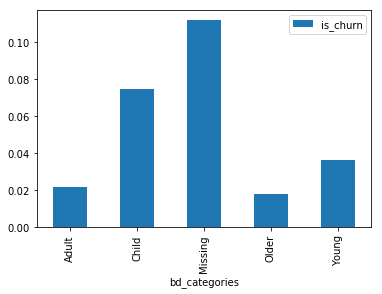

In [38]:
import matplotlib.pyplot as plt
age_pivot = train_tran1.pivot_table(index="bd_categories", values="is_churn")
age_pivot.plot.bar()
plt.show()

In [36]:
from sklearn.metrics import log_loss
#print(log_loss(train['is_churn'],test_predictions))
print(log_loss(train2['is_churn'], test_predictions4))

0.290590055016


In [25]:
test_predictions.shape


(907471,)

In [18]:
test_predictionsx = pd.read_csv("test_predictions.csv")
test_predictionsx['5'] = test_predictions5

In [24]:
test_predictions = test_predictionsx.mean(axis=1)

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [6]:
df_x = train_tran1[predictors]
df_y = train_tran1['is_churn']

In [7]:
x_train,x_test,y_train, y_test = train_test_split(df_x,df_y, test_size=0.3, random_state= 4)

In [8]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [9]:
dt.score(x_test,y_test)

0.93348507319216723

In [11]:
train_tran1["dec_sci_col"] = dt.predict_proba(train_tran1[predictors])[:,1]
test_tran1["dec_sci_col"] = dt.predict_proba(test_tran1[predictors])[:,1]

In [26]:
rf = RandomForestClassifier(n_estimators=200)
#rf.fit(x_train, y_train)
rf.fit(train[predictors], train['is_churn'])
train_predictions = rf.predict_proba(train[predictors])[:,1]
test_predictions = rf.predict_proba(test[predictors])[:,1]

In [11]:
rf.score(x_test,y_test)

0.93348164016368684

In [12]:
rf.score(x_train,y_train)

0.99636000894549137

In [13]:
train_tran1["rand_sci_col"] = rf.predict_proba(train_tran1[predictors])[:,1]
test_tran1["rand_sci_col"] = rf.predict_proba(test_tran1[predictors])[:,1]

In [14]:
bg = BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, max_features=1.0, n_estimators =20)
bg.fit(x_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.5, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [17]:
bg.score(x_test, y_test)

0.95566587020405924

In [15]:
train_tran1["bag_sci_col"] = bg.predict_proba(train_tran1[predictors])[:,1]
test_tran1["bag_sci_col"] = bg.predict_proba(test_tran1[predictors])[:,1]

In [25]:
adb = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators = 10, learning_rate = 0.001)
adb.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=10, random_state=None)

In [26]:
adb.score(x_test, y_test)

0.93526681497349706

In [16]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
svm = SVC(kernel = 'poly', degree = 2)

In [9]:
evc = VotingClassifier(estimators=[('lr', lr), ('dt', dt), ('svm', svm)], voting = 'hard')

In [ ]:
evc.fit(x_train.iloc[1:1000], y_train[1:1000])

In [17]:
lr.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
lr.score(x_test, y_test)

0.91027436763615388

In [25]:
lr.score(x_train, y_train)

0.90996539507291752

In [18]:
train_tran1["lr_sci_col"] = lr.predict_proba(train_tran1[predictors])[:,1]
test_tran1["lr_sci_col"] = lr.predict_proba(test_tran1[predictors])[:,1]

In [26]:
test_predictions = (test_tran1["bag_sci_col"] + test_tran1["rand_sci_col"]+ test_tran1["lr_sci_col"] + test_predictions + test_tran1["dec_sci_col"])/5